In [0]:
import os
from itertools import product
from typing import Callable, Union

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import statsmodels.api as sm
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.exceptions import NotFittedError
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm

In [0]:
class KernelDensityEstimator:
    """
    
    """
    def __init__(
            self, kernel: Union[str, Callable[[float, float], float]], width: float = None, precision: int = 10_000
    ):
        """
        :param kernel: str or callable kernel, if str valid options are `gaussian`, `epa`, `triang`
        :param width: width of estimators kernel
        :param precision: optional parameter defining precision of rounding point during predict
        """
        # public properties
        self.bins = None
        self.width = width
        # private params
        self._kernel = _DENSITY_KERNELS[kernel] if type(kernel) is str else kernel
        self._precision = precision
        # placeholders
        self._distribution = None
        self._spacing = None
        self._values = None

    def fit(self, realization: np.array) -> None:
        """
        :param realization: random variable realization for which
                            probability density  will be estimated,
                            must have at least 2 samples
        """
        self._distribution = realization
        self._spacing = np.linspace(realization.min(), realization.max(), self._precision)
        self.bins = self._distribution.shape[0]

        self._values = np.sum(np.vectorize(self._point_kernel, signature="()->(n)")(realization), axis=0)

    def _point_kernel(self, point: float):
        return self._kernel((self._spacing - point) / self.width, self.width)

    def _estimate(self, x: float) -> float:
        if self._distribution is None:
            raise NotFittedError

        nearest_value = np.argmin(np.abs(self._spacing - x))
        return (1 / (self.width * self.bins)) * self._values[nearest_value]

    def predict(self, values: float) -> float:
        """
        Returns cumulative distribution function value at any point

        :param values: value or array of values to compute histogram for

        :raises NotFittedError: when called prior to calling fit function

        :return: array of histogram values
        """
        return np.vectorize(self._estimate)(values)


In [0]:
def ep_kernel(x, h):
    value = 1 - (np.power(x, 2) / np.power(h, 2))
    return (value > 0) * value

In [0]:
def gau_kernel(x, h):
    return np.exp(-1*(np.power(x, 2) / (2 * np.power(h, 2))))

In [0]:
def cos_kernel(x, h):
    return (np.abs(x) - h < 0) * np.cos((np.pi * x) / (2 * h))

In [0]:
def tophat_kernel(x, h):
    return 1 * (np.abs(x) - h < 0)

In [0]:
def linear_kernel(x, h):
    return (x > 0) * (1 - x / h) * (x - h < 0) + (x < 0) * (1 + x / h) * (x + h > 0)

In [0]:
def exp_kernel(x, h):
    return np.exp(-x/h) * (x > 0) + np.exp(x/h) * (x < 0)

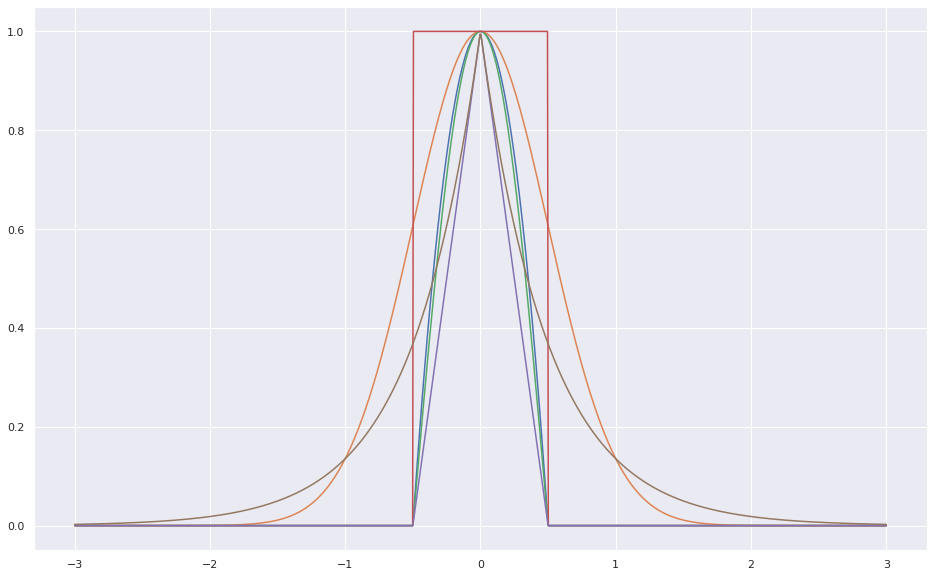

In [186]:
figure = plt.figure(figsize=[16, 10])

x = np.linspace(-3, 3, 1000)

_ = plt.plot(x, ep_kernel(x, 0.5))
_ = plt.plot(x, gau_kernel(x, 0.5))
_ = plt.plot(x, cos_kernel(x, 0.5))
_ = plt.plot(x, tophat_kernel(x, 0.5))
_ = plt.plot(x, linear_kernel(x, 0.5))
_ = plt.plot(x, exp_kernel(x, 0.5))

In [0]:
distribution = stats.norm.rvs(size=1000)
estimator = KernelDensityEstimator(kernel=cos_kernel, width=0.8)
estimator.fit(distribution)

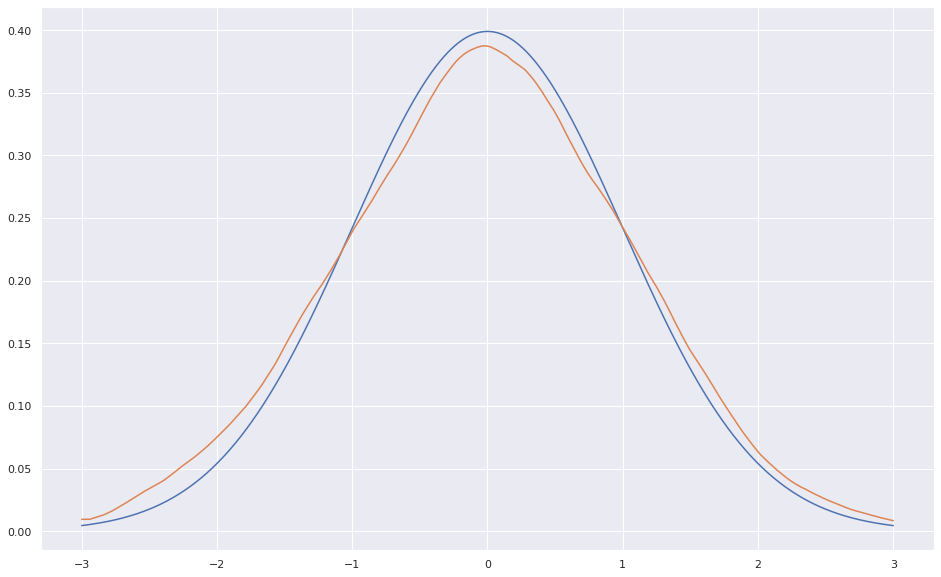

In [122]:
figure = plt.figure(figsize=[16, 10])

x = np.linspace(-3, 3, 1000)

_ = plt.plot(x, stats.norm.pdf(x))
_ = plt.plot(x, estimator.predict(x))